In [1]:
import typing
import pandas as pd
import plotly.graph_objects as pgo
import plotly.subplots as ps

from pathlib import Path
from datapaths import *

pd.set_option('display.max_rows', 2)

In [3]:
groups = ("G4", "Z-DNA", "SIDD", "H-DNA")[::-1]
annotations = (
    "Promoter (≤1kb)",
    "Promoter (1-2kb)",
    "Promoter (2-3kb)",
    "5' UTR",
    "Exon",
    "Intron",
    "3' UTR",
    "Downstream (≤300bp)",
    "Distal Intergenic",
)
feature_groups = (
    "cCRE",
    "LINE/LTR",
    "cCRE &<br>LINE/LTR",
    "CTCF",
    "cCRE &<br>CTCF",
    "LINE/LTR &<br>CTCF",
    "cCRE &<br>LINE/LTR &<br>CTCF",
)
c_mir_list = ['c. miR (+)', 'c. miR (-)', 'c. MJ miR (+)', 'c. MJ miR (-)', 'c. J miR (+)', 'c. J miR (-)']

In [6]:
def get_plotly_data(flipons_to_data: pd.DataFrame) -> pd.DataFrame:
    result = (
        flipons_to_data
        .loc[:, ["Feature Group", "Gene Feature", "Flipon"]]
        .groupby(["Gene Feature", "Feature Group"])[["Flipon"]]
        .value_counts()
        .to_frame()
        .rename(columns={0: "count"})
        .reset_index()
    )
    result['Feature Group'] = result['Feature Group'].str.replace('& ', '&<br>')
    result = result[result['Feature Group'] != ''].replace(
        {"g4": "G4", "z-dna": "Z-DNA", "h-dna": "H-DNA", "sidd": "SIDD"}
    )
    result['Gene Feature'] = result['Gene Feature'].str.replace('<=', '≤')

    return result


def plot_matrix(
    groups: typing.Iterable,
    annotations: typing.Iterable,
    feature_groups: typing.Iterable,
    plotly_data: pd.DataFrame,
    title: str = "Generic Title",
    fig_title: str = "figure.png",
    height: int = 900,
    width: int = 1800,
):
    colors = {
        # "G4": "rgb(245,139,0)",
        "G4": "rgb(227,158,34,.5)",
        # "Z-DNA": "rgb(0,112,245)",
        "Z-DNA": "#4779A4",
        # "SIDD": "rgb(255,49,38)",
        "SIDD": "#C93435",
        # "H-DNA": "rgb(159,75,201)",
        "H-DNA": "#9F637C",
    }
    n_rows = len(feature_groups)
    n_cols = len(annotations)
    fig = ps.make_subplots(
        rows=n_rows,
        cols=n_cols,
        shared_xaxes="all",
        shared_yaxes="all",
        horizontal_spacing=0.004,
        vertical_spacing=0.01,
        column_titles=annotations,
        row_titles=feature_groups,
        x_title="Flipon count",
    )

    for i, feature_group in enumerate(feature_groups):
        for j, annotation in enumerate(annotations):
            df = (
                plotly_data[
                    (plotly_data["Feature Group"] == feature_group)
                    & (plotly_data["Gene Feature"] == annotation)
                ]
                .set_index("Flipon")
                .reindex(groups)
                .dropna()
            )
            if not len(df):
                continue

            # https://stackoverflow.com/questions/70347594/how-to-format-plotly-legend-when-using-marker-color
            for idx, row in df.iterrows():
                sub = pgo.Bar(
                    x=[row["count"]],
                    y=[idx],
                    name=idx,
                    textposition="outside"
                    if row["count"] < plotly_data["count"].max() // 1.5
                    else "inside",
                    texttemplate="%{x:,d}",
                    marker=dict(color=colors[idx]),
                    width=0.95,
                    orientation="h",
                    showlegend=True if (i == 0 and j == 0) else False,
                )
                fig.add_trace(sub, row=i + 1, col=j + 1)
            fig.update_xaxes(ticks="", row=i + 1, col=j + 1)

    fig.update_xaxes(
        tickformat="s",
        showgrid=False,
        tickmode="array",
        tickvals=[round(plotly_data["count"].max() / 5, -3) * i for i in range(0, 5)],
    )
    fig.update_xaxes(ticks="outside", row=n_rows)
    fig.update_yaxes(type="category", visible=False)
    fig.update_annotations(textangle=0, font=dict(size=18), align="left")
    fig.update_layout(
        title=f"<span style='font-size: 20px;'>{title}</span>",
        title_x=0.005,
        title_y=0.99,
        height=height,
        width=width,
        font=dict(size=16),
        uniformtext_minsize=16,
        margin=dict(l=5, t=55, b=55, r=65),
        legend=dict(
            font_size=16,
            traceorder="reversed",
            orientation="h",
            yanchor="bottom",
            y=1.03,
            xanchor="right",
            x=0.98,
        ),
        template="ggplot2",
    )

    fig.write_image(D_IMG / fig_title, scale=2)
    fig.show(renderer='png')


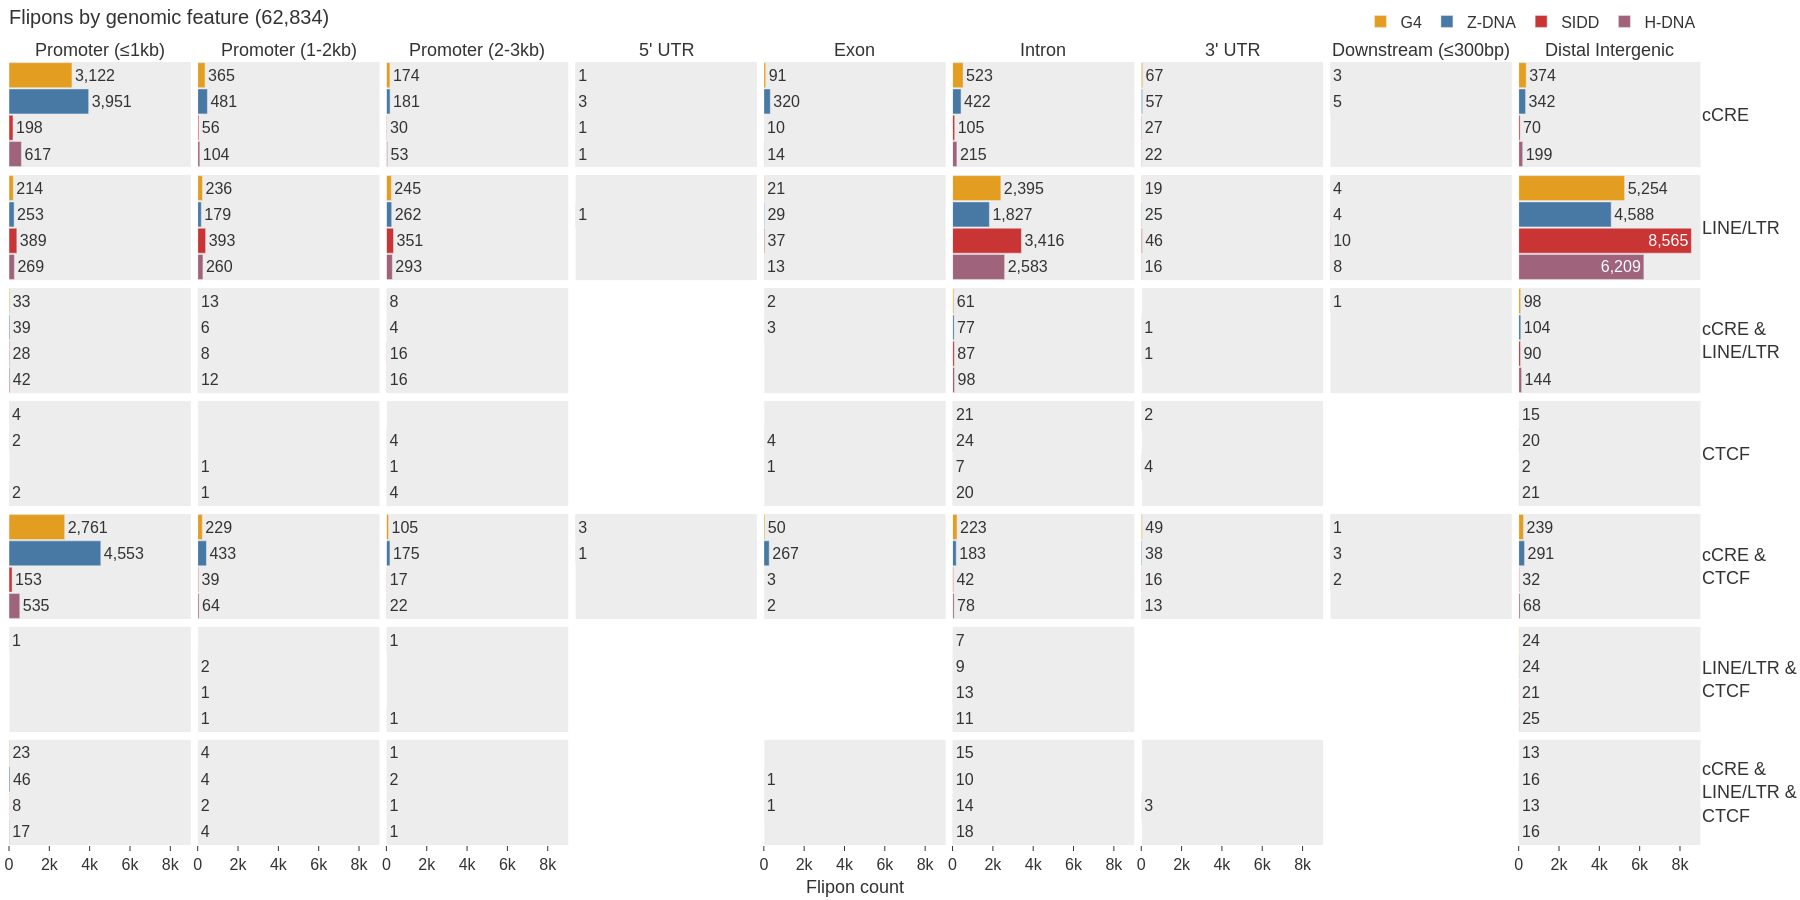

In [7]:
flipons_to_data= pd.read_table(F_FLIPON_TO_DATA).fillna('')
data_all = get_plotly_data(flipons_to_data)
plot_matrix(
    groups,
    annotations,
    feature_groups,
    plotly_data=data_all,
    title=f"Flipons by genomic feature ({data_all['count'].sum():,d})",
    fig_title="Figure.2A.png",
)

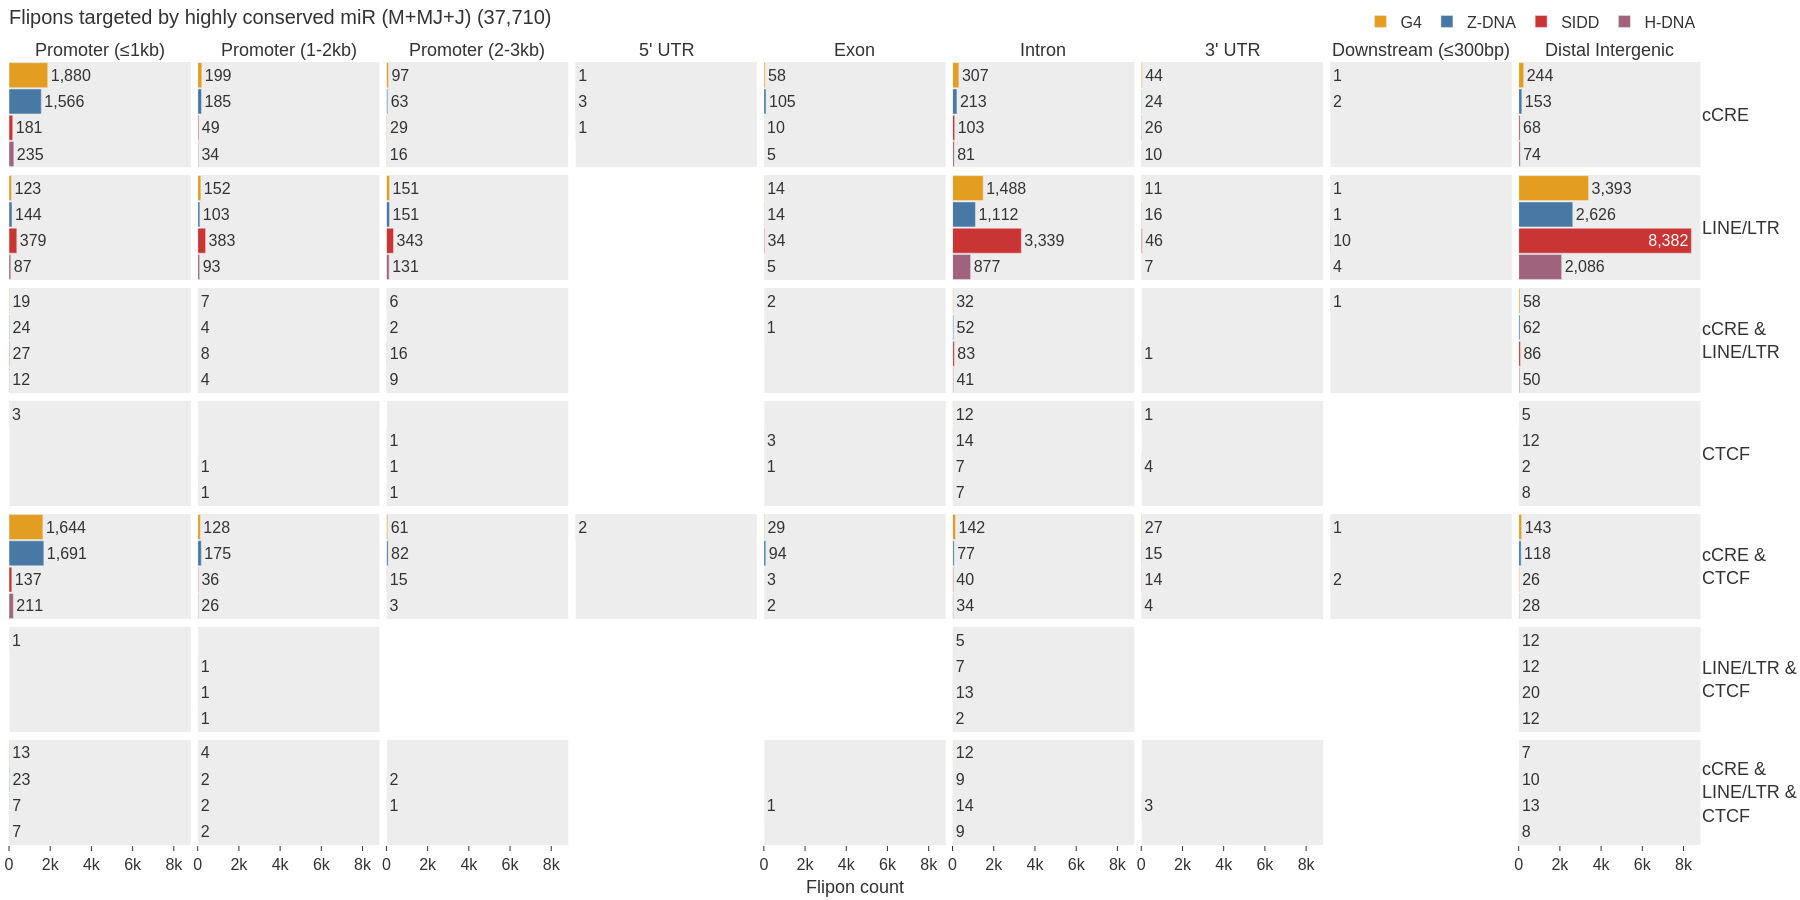

In [19]:
data_mirna = get_plotly_data(flipons_to_data[(flipons_to_data[c_mir_list] != '').sum(axis=1) > 0])
plot_matrix(
    groups,
    annotations,
    feature_groups,
    plotly_data=data_mirna,
    title=f"Flipons targeted by highly conserved miR (M+MJ+J) ({data_mirna['count'].sum():,d})",
    fig_title="Figure.2B.png",
)


## Merge two tables into one

In [6]:
data_merged = pd.concat([data_all.assign(group='All flipons'), data_mirna.assign(group='Flipons & miRNA')], ignore_index=True)
data_merged

,Gene Feature,Feature Group,Flipon,count,group
0,3' UTR,CTCF,SIDD,4,All flipons
...,...,...,...,...,...
340,Promoter (≤1kb),cCRE &<br>LINE/LTR &<br>CTCF,H-DNA,3,Flipons & miRNA


In [7]:
def plot_matrix_merged(
    groups: typing.Iterable,
    annotations: typing.Iterable,
    feature_groups: typing.Iterable,
    plotly_data: pd.DataFrame,
    title: str = "Generic Title",
    fig_title: str = "figure.png",
    height: int = 1600,
    width: int = 1800,
):
    colors = {
        # "G4": "rgb(245,139,0)",
        "G4": "rgb(227,158,34)",
        # "Z-DNA": "rgb(0,112,245)",
        "Z-DNA": "#4779A4",
        # "SIDD": "rgb(255,49,38)",
        "SIDD": "#C93435",
        # "H-DNA": "rgb(159,75,201)",
        "H-DNA": "#9F637C",
    }
    n_rows = len(feature_groups)
    n_cols = len(annotations)
    fig = ps.make_subplots(
        rows=n_rows,
        cols=n_cols,
        shared_xaxes="all",
        shared_yaxes="all",
        horizontal_spacing=0.004,
        vertical_spacing=0.01,
        column_titles=annotations,
        row_titles=feature_groups,
        x_title="Flipon count",
    )

    for i, feature_group in enumerate(feature_groups):
        for j, annotation in enumerate(annotations):
            for k, group in enumerate(['Flipons & miRNA', 'All flipons']):
                df = (
                    plotly_data[
                        (plotly_data["Feature Group"] == feature_group)
                        & (plotly_data["Gene Feature"] == annotation)
                        & (plotly_data["group"] == group)
                    ]
                    .set_index("Flipon")
                    .reindex(groups)
                    .dropna()
                )

                if not len(df):
                    continue

                # https://stackoverflow.com/questions/70347594/how-to-format-plotly-legend-when-using-marker-color
                for idx, row in df.iterrows():
                    sub = pgo.Bar(
                        x=[row["count"]],
                        y=[idx],
                        name=idx,
                        textposition="outside"
                        if row["count"] < plotly_data["count"].max() // 1.5
                        else "inside",
                        texttemplate="%{x:,d}",
                        marker=dict(color=colors[idx], pattern=dict(shape='/', size=5, solidity=.25) if k==0 else None),
                        width=0.5,
                        orientation="h",
                        legendgroup=group,
                        showlegend=True if (i == 0 and j == 0 and k != 0) else False,
                    )
                    fig.add_trace(sub, row=i + 1, col=j + 1)
                fig.update_xaxes(ticks="", row=i + 1, col=j + 1)

    fig.update_xaxes(
        tickformat="s",
        showgrid=False,
        tickmode="array",
        tickvals=[round(plotly_data["count"].max() / 4, -3) * i for i in range(0, 4)],
    )
    fig.update_xaxes(ticks="outside", row=n_rows)
    fig.update_yaxes(type="category", visible=False)
    fig.update_annotations(textangle=0, font=dict(size=14), align="left")
    fig.update_layout(
        title=f"<span style='font-size: 16px;'>{title}</span>",
        title_x=0.005,
        title_y=0.99,
        height=height,
        width=width,
        font=dict(size=14),
        uniformtext_minsize=14,
        margin=dict(l=5, t=55, b=55, r=60),
        legend=dict(
            font_size=14,
            traceorder="reversed",
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=0.98,
        ),
        template="ggplot2",
        barmode='group',
        bargap=0,
        # bargroupgap=0.1,
    )

    fig.write_image(D_IMG / fig_title, scale=1)
    fig.show(renderer='png')


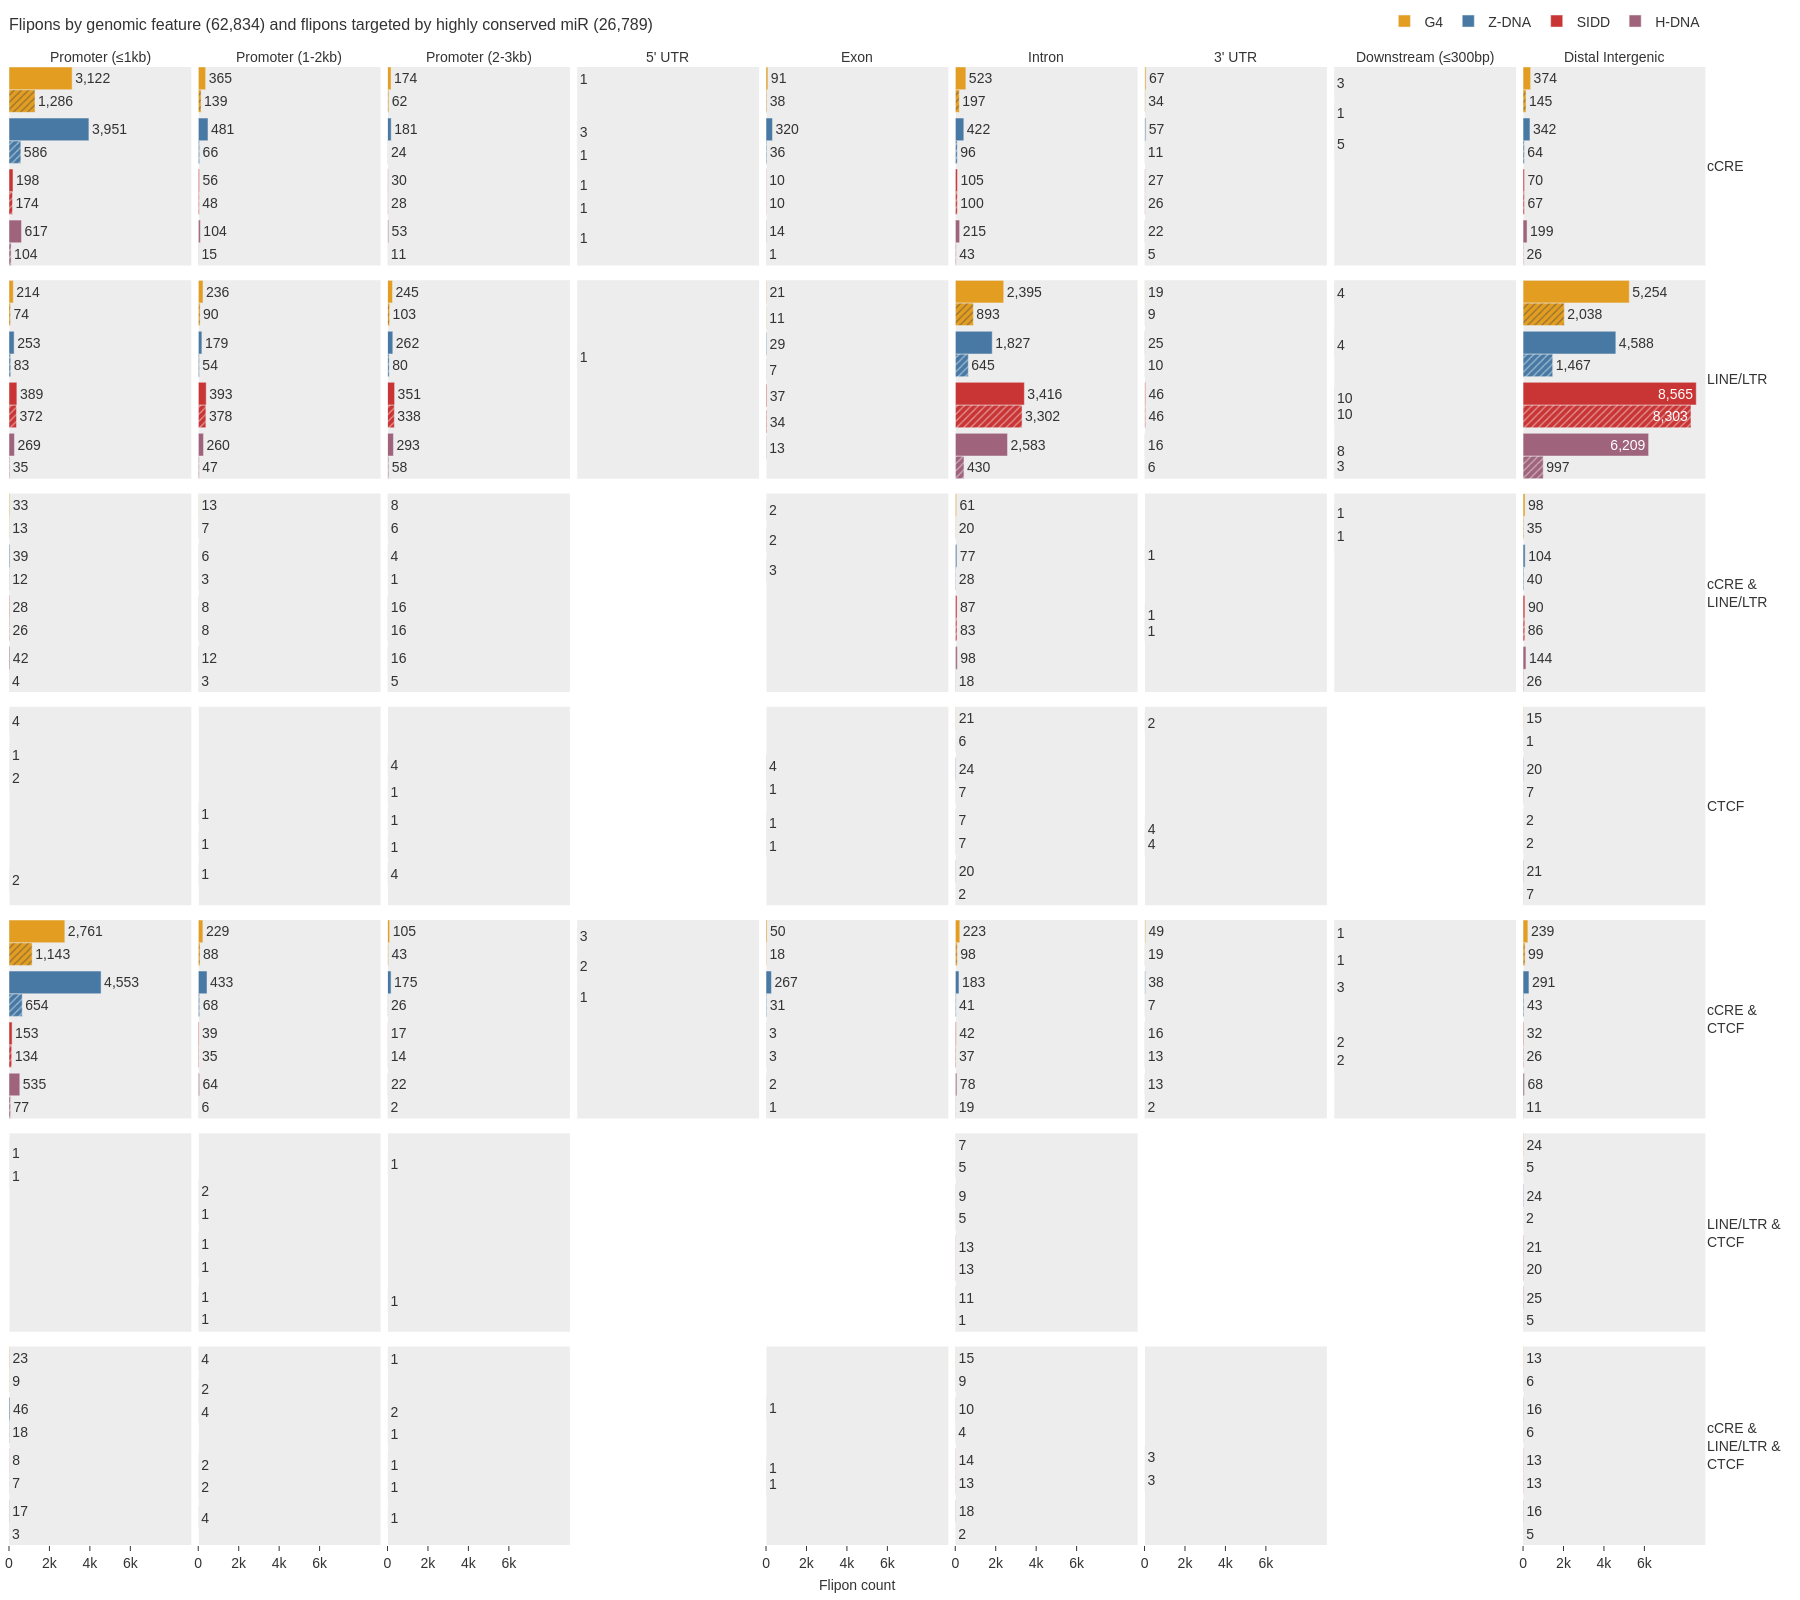

In [8]:
plot_matrix_merged(
    groups,
    annotations,
    feature_groups,
    plotly_data=data_merged,
    title=f"Flipons by genomic feature ({data_all['count'].sum():,d}) and flipons targeted by highly conserved miR ({data_mirna['count'].sum():,d})",
    fig_title="Figure.2.merged.png",
)